### Step 4.3: Cluster individual traces

__Step goals:__ Cluster generated individual traces with Gaussian Mixture Model.

__Step overview:__
1. Load the data and prepare the features;
2. Perform GMM;
3. Save the result.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import numpy as np
import pickle
import math
from tqdm import tqdm
import itertools
from sklearn.mixture import GaussianMixture
plt.style.use('science')

1. Load the data

In [2]:
# Load the data
data_type = 'entry'
entry_individual = pd.read_csv(f"../data/interim/counts/{data_type}_individual.csv")
print(f'Clustering will be performed on : {entry_individual.shape[0]} points.')
X = entry_individual["time_stamp"].values
X = X.reshape(-1, 1)

Clustering will be performed on : 4571040 points.


2. Clustering

In [ ]:
%%time
# Specify hyper-parameters
n_components = 10
random_state = 12345
n_init = 50

# Train the model
model = GaussianMixture(n_components, covariance_type='full', random_state=random_state, n_init=n_init, verbose=2).fit(X)

# Get the parameters
labels = model.predict(X)
weights = model.weights_
probs = np.around(model.predict_proba(X), 3)
means = model.means_
covariances = model.covariances_

Initialization 0


3. Save the result

In [ ]:
# Save the model
filename = f'../models/individual_traces/gmm_{data_type}_{n_components}.sav'
pickle.dump(model, open(filename, 'wb')) 

# Save parameters
np.save(f"../data/interim/gmm/individual_traces/labels_{n_components}_{data_type}.npy", labels)
np.save(f"../data/interim/gmm/individual_traces/weights_{n_components}_{data_type}.npy", weights)
np.save(f"../data/interim/gmm/individual_traces/probs_{n_components}_{data_type}.npy", probs)
np.save(f"../data/interim/gmm/individual_traces/means_{n_components}_{data_type}.npy", means)
np.save(f"../data/interim/gmm/individual_traces/covariances_{n_components}_{data_type}.npy", covariances)

4. Generating synthetic stations

In [22]:
# Load the data
data_type = 'entry'
data = pd.read_csv(f"../data/interim/counts/{data_type}_individual.csv").drop(['station_id', 'time_stamp'], axis=1)

In [23]:
# Load the models
k = 7
file_name = f'../models/individual_traces/gmm_{data_type}_{k}.sav'
with open(file_name, 'rb') as f:
    model = pickle.load(f)
labels = np.load(f"../data/interim/gmm/individual_traces/labels_{k}_{data_type}.npy", allow_pickle=True)   
probs = np.load(f"../data/interim/gmm/individual_traces/probs_{k}_{data_type}.npy", allow_pickle=True)   

In [24]:
# Combine stations with probabilities
df = pd.concat([data, pd.DataFrame(probs)], axis=1)
print(df.head())

# Groupby probabilities = cluster labels by station
df = df.groupby('station').sum()
print(df.head())

      station      0      1    2      3      4      5      6
0  Acton Town  0.000  0.919  0.0  0.000  0.062  0.000  0.019
1  Acton Town  0.000  0.150  0.0  0.000  0.000  0.000  0.850
2  Acton Town  0.183  0.000  0.0  0.813  0.004  0.000  0.000
3  Acton Town  0.851  0.000  0.0  0.145  0.000  0.004  0.000
4  Acton Town  0.183  0.000  0.0  0.813  0.004  0.000  0.000
                     0         1         2         3         4         5  \
station                                                                    
Acton Town    2042.957  2585.867   379.103  1462.913  1360.477   551.474   
Aldgate       6488.204  2189.137   760.385  1994.754  1277.019  1610.769   
Aldgate East  7658.520  2736.467  2094.154  3585.397  2802.567  2640.601   
Alperton       801.999  1198.528   163.500   563.211   559.856   263.383   
Amersham       549.900  1282.715    40.750   384.998   366.255    83.440   

                     6  
station                 
Acton Town    1328.326  
Aldgate        674.474  
A

In [25]:
# Get means and std
means = model.means_
covariances = model.covariances_
sigmas = [math.sqrt(covariance) for covariance in covariances]

In [26]:
# Container for sampled stations
sample = []

100%|████████████████████████████████████████████████████████████████████████████████| 264/264 [00:14<00:00, 18.73it/s]


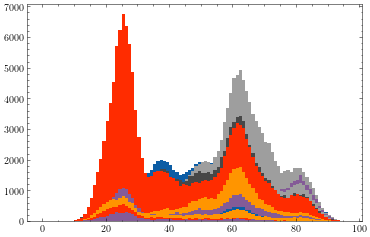

In [27]:
# 
for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    station = []
    # Sample individual entries at a station 
    # based on their cluster (mean and std)
    for i, j in zip(row, range(0, k)):
        station.append(np.random.normal(means[j], sigmas[j], int(i)))
    # Flatten the list of lists 
    merged = list(itertools.chain(*station))
    # Aggregate individual entries to bins
    n, bins, patches = plt.hist(merged, bins=range(0, 97, 1))
    sample.append(n)

In [28]:
sample = pd.DataFrame(sample)
sample.index = df.index
print(sample.head())

               0    1    2    3    4    5    6    7    8    9   ...    86  \
station                                                         ...         
Acton Town    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  2.0  ...  21.0   
Aldgate       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  36.0   
Aldgate East  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  94.0   
Alperton      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...   7.0   
Amersham      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   2.0   

                87    88    89    90    91    92   93   94   95  
station                                                          
Acton Town    13.0  10.0   3.0   3.0   1.0   2.0  0.0  0.0  1.0  
Aldgate       24.0  19.0  10.0   2.0   5.0   3.0  0.0  1.0  1.0  
Aldgate East  78.0  42.0  32.0  21.0  12.0  12.0  1.0  5.0  0.0  
Alperton       3.0   6.0   1.0   2.0   2.0   0.0  0.0  0.0  0.0  
Amersham       1.0   3.0   0.0   2.0   0.0   0.0  0.0  0.0  0.0 

In [29]:
# Get column names
gdf = gpd.read_file('../data/interim/counts/entry_station_cluster.json')

columns = gdf.loc[:,'0200-0215':'0145-0200'].columns

# Assign column names
sample.columns = columns

In [30]:
# Define label names and corresponding colors
label_names = ["Inner residential", "Polycenter", "CBD", "Mixed commuting", "Outer residential", "Potential feeder"]
label_color_map = {"Outer residential": "#FF2C00", "CBD": "#00B945", "Polycenter": "#845B97", 
                   "Inner residential": "#FF9500", "Potential feeder": "#0C5DA5", "Mixed commuting": "#474747"}

In [31]:
gdf.set_index('station_name', inplace=True)

In [32]:
# Merge gdf with assigned clust labels with our sampled stations
merged = pd.merge(sample, gdf[['label', 'label_name']], left_index=True, right_index=True)
# Arguments needed for viz
labels = merged['label']
label_names = ["Inner residential", "Polycenter", "CBD", "Mixed commuting", "Outer residential", "Potential feeder"]

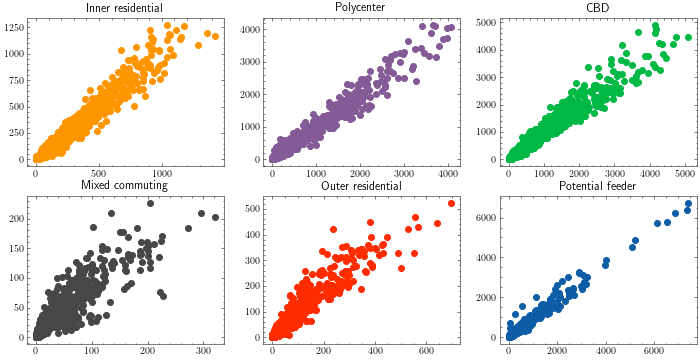

In [33]:
nrows=2
ncols=3
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12,6))
stations = sample.index.tolist()
k = 0
for row in range(0, nrows):
    for col in range(0, ncols):
        x = gdf[gdf['label'] == k].loc[:,'0200-0215':'0145-0200']
        y = merged[merged['label'] == k].loc[:,'0200-0215':'0145-0200']
        stations = x.index.tolist()
        for station in stations:
            ax[row,col].scatter(x.loc[station,:], y.loc[station,:], color=label_color_map[label_names[k]])
        ax[row,col].set_title(label_names[k])
        k += 1

In [34]:
from src.visualization.visualize import plot_counts

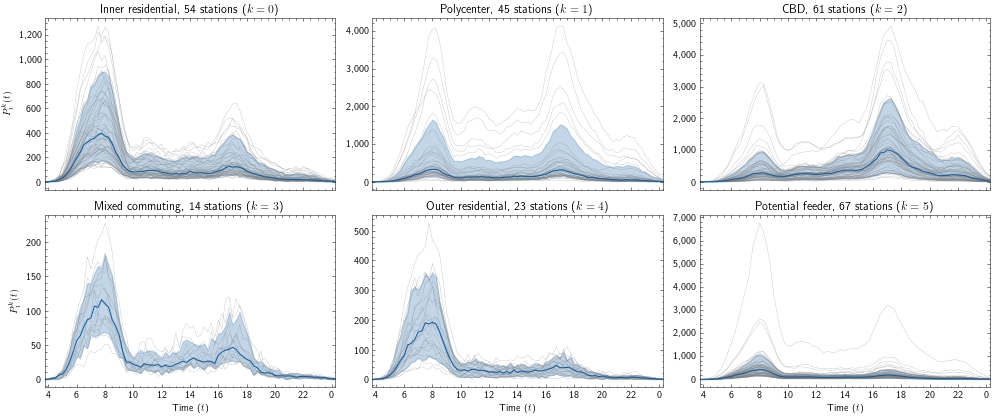

In [35]:
# Plot the result
plot_counts(merged, labels, 6, label_names=label_names, plot_median=True, sharex=True, savefig=False)